In [ ]:
#БЛОК 1 - Генерація даних (контрольований «бруд»)

In [17]:
import os
import random
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

# ---------- Параметри / фіксація seed ----------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Кількість рядків
num_rows = 12000

# ---------- Папки для збереження ----------
os.makedirs("../data/raw", exist_ok=True)
os.makedirs("../data/clean", exist_ok=True)

# ---------- 1) booking_id ----------
booking_id = [f"BKG{str(i).zfill(6)}" for i in range(1, num_rows + 1)]

# ---------- 2) created_at ----------
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 8, 31)
range_days = (end_date - start_date).days + 1

created_at = []
for _ in range(num_rows):
    day = start_date + timedelta(days=int(np.random.randint(0, range_days)))
    dt = day + timedelta(hours=int(np.random.randint(0, 24)), minutes=int(np.random.randint(0, 60)))
    created_at.append(dt)

num_ddmm = int(0.12 * num_rows)
ddmm_idx = np.random.choice(num_rows, size=num_ddmm, replace=False)
for i in ddmm_idx:
    created_at[i] = created_at[i].strftime("%d.%m.%Y %H:%M")

# ---------- 3) nights ----------
nights = np.random.lognormal(mean=1.5, sigma=0.75, size=num_rows).astype(int)
nights = np.clip(nights, 1, 21)
num_nights_anom = int(0.006 * num_rows)
anom_idx = np.random.choice(num_rows, size=num_nights_anom, replace=False)
for j, idx in enumerate(anom_idx):
    nights[idx] = 0 if j % 2 == 0 else 75

# ---------- 4) check_in, check_out ----------
check_in = []
for dt in created_at:
    if isinstance(dt, str):
        dt_parsed = datetime.strptime(dt, "%d.%m.%Y %H:%M")
    else:
        dt_parsed = dt
    offset_days = int(np.random.randint(0, 121))
    check_in.append(dt_parsed + timedelta(days=offset_days))

check_out = [ci + timedelta(days=int(nl)) for ci, nl in zip(check_in, nights)]
num_logic_err = int(0.01 * num_rows)
logic_err_idx = np.random.choice(num_rows, size=num_logic_err, replace=False)
for idx in logic_err_idx:
    if np.random.rand() < 0.5:
        check_out[idx] = check_in[idx] - timedelta(days=int(np.random.randint(0, 3)))
    else:
        nights[idx] = max(0, (check_out[idx] - check_in[idx]).days + int(np.random.randint(1, 3)))

# ---------- 5) hotel_id, hotel_city ----------
num_hotels = 20
hotel_ids = [f"H{1000 + i}" for i in range(num_hotels)]
hotel_id = np.random.choice(hotel_ids, size=num_rows)
cities_dirty = ['Kyiv', 'kyiv', 'Lviv', 'Lviv ', 'Odesa', 'ODESA', ' K y i v ']
hotel_city = np.random.choice(cities_dirty, size=num_rows)

# ---------- 6) room_type ----------
room_types_master = ['STD', 'Standard', 'DBL', 'Double', 'TWIN', 'Suite', 'Family', 'Famly', 'APART', 'Apartment']
room_type = np.random.choice(room_types_master, size=num_rows)

# ---------- 7) guests ----------
guests_adults = np.random.randint(1, 5, size=num_rows)
guests_children = np.random.randint(0, 3, size=num_rows)
num_zero_guests = int(0.005 * num_rows)
zero_guest_idx = np.random.choice(num_rows, size=num_zero_guests, replace=False)
for idx in zero_guest_idx:
    guests_adults[idx] = 0
    guests_children[idx] = 0
num_str_guests = int(0.06 * num_rows)
str_guests_idx = np.random.choice([i for i in range(num_rows) if i not in zero_guest_idx], size=num_str_guests, replace=False)
guests_adults_dirty = guests_adults.astype(object).copy()
guests_children_dirty = guests_children.astype(object).copy()
for idx in str_guests_idx:
    guests_adults_dirty[idx] = f"{guests_adults[idx]} adults"
    guests_children_dirty[idx] = f"{guests_children[idx]} children"

# ---------- 8) board ----------
boards = ['BB', 'bb', 'HB', 'HB ', 'AI', 'RO', 'room only', 'half board', 'all inclusive']
board = np.random.choice(boards, size=num_rows)
num_board_na = int(np.random.uniform(0.06, 0.10) * num_rows)
board_na_idx = np.random.choice(num_rows, size=num_board_na, replace=False)
for i in board_na_idx:
    board[i] = np.nan

# ---------- 9) channel ----------
channel_variants = ['direct', 'Direct', 'ota_x', 'OTA-X ', 'ota_y', 'OTA_Y', ' ota_x ']
channel = np.random.choice(channel_variants, size=num_rows)

# ---------- 10) currency, price, price_uah ----------
currencies = ['UAH', 'EUR', 'USD']
fx_rates = {'UAH': 1.0, 'EUR': 50.0, 'USD': 41.5}
currency = np.random.choice(currencies, size=num_rows)
price = np.round(np.random.lognormal(mean=7, sigma=0.5, size=num_rows), 2).astype(object)
num_text_prices = int(0.10 * num_rows)
text_price_idx = np.random.choice(num_rows, size=num_text_prices, replace=False)
for idx in text_price_idx:
    val = float(price[idx])
    price[idx] = f"{int(val):,}".replace(",", " ") + ",50"
num_contract = int(0.01 * num_rows)
contract_idx = np.random.choice([i for i in range(num_rows) if i not in text_price_idx], size=num_contract, replace=False)
for idx in contract_idx:
    price[idx] = "договірна"
num_neg_prices = int(0.007 * num_rows)
neg_price_idx = np.random.choice([i for i in range(num_rows) if not isinstance(price[i], str)], size=num_neg_prices, replace=False)
for idx in neg_price_idx:
    price[idx] = -abs(float(price[idx]))
price_uah = np.empty(num_rows, dtype=object)
for i in range(num_rows):
    price_uah[i] = np.nan  # залишаємо брудні дані

# ---------- 11) payment_status ----------
payment_status_options = ['paid', 'unpaid', 'refund']
payment_status = np.random.choice(payment_status_options, size=num_rows, p=[0.85, 0.10, 0.05])

# ---------- 12) customer_id ----------
num_customers = int(np.random.randint(6000, 9001))
customer_ids = np.arange(6000, 6000 + num_customers)
customer_id = np.random.choice(customer_ids, size=num_rows, replace=True)

# ---------- 13) country ----------
countries_base = ['UA', 'GB', 'PL', 'RU']
country = np.random.choice(countries_base, size=num_rows)
num_country_na = int(np.random.uniform(0.07, 0.10) * num_rows)
country_na_idx = np.random.choice(num_rows, size=num_country_na, replace=False)
for i in country_na_idx:
    country[i] = np.nan
for i in np.random.choice(range(num_rows), size=int(0.1 * num_rows), replace=False):
    if pd.notna(country[i]):
        if np.random.rand() < 0.5:
            country[i] = country[i].lower()
        if np.random.rand() < 0.2:
            country[i] = " " + str(country[i]) + " "

# ---------- 14) Відгуки (заповнені брудно) ----------
review_id = [np.nan] * num_rows
review_date = [np.nan] * num_rows
rating = [np.nan] * num_rows
review_lang = [np.nan] * num_rows
review_text = [np.nan] * num_rows

num_reviews = int(0.3 * num_rows)  # 30% бронювань мають відгуки
review_idx = np.random.choice(num_rows, size=num_reviews, replace=False)

langs = ['en', 'uk', 'ru']
for i in review_idx:
    review_id[i] = f"RVW{str(i).zfill(6)}"
    # Дата відгуку може бути після check_out або з логічною помилкою
    dt = check_out[i] + timedelta(days=int(np.random.randint(-2, 5)))
    if np.random.rand() < 0.1:
        dt = dt.strftime("%d.%m.%Y")  # брудний формат
    review_date[i] = dt
    # Оцінка від 1 до 10, з 10% шансом аномалії
    rating[i] = np.random.randint(1, 11) if np.random.rand() > 0.1 else np.random.randint(-3, 15)
    # Мова відгуку
    review_lang[i] = np.random.choice(langs)
    # Текст відгуку, частково пусті
    review_text[i] = np.random.choice([
        "Great stay!", "Very clean.", "Would not recommend.", "", np.nan
    ])

# ---------- 15) DataFrame ----------
df = pd.DataFrame({
    'booking_id': booking_id,
    'created_at': created_at,
    'check_in': check_in,
    'check_out': check_out,
    'nights': nights,
    'hotel_id': hotel_id,
    'hotel_city': hotel_city,
    'room_type': room_type,
    'guests_adults': guests_adults_dirty,
    'guests_children': guests_children_dirty,
    'board': board,
    'channel': channel,
    'price': price,
    'currency': currency,
    'price_uah': price_uah,
    'payment_status': payment_status,
    'customer_id': customer_id,
    'country': country,
    'review_id': review_id,
    'review_date': review_date,
    'rating': rating,
    'review_lang': review_lang,
    'review_text': review_text
})

# ---------- 16) Збереження файлу ----------
out_path = "../data/raw/generated_dirty.csv"
df.to_csv(out_path, index=False)
print("Файл збережено:", out_path)

# ---------- 17) Коротка діагностика / вивід, щоб перевірити патерни ----------
print("Збережено:", out_path)
print("Розмір датафрейму:", df.shape)
print("\nПриблизні частки та кількості (контрольні):")
print(" - частка created_at у DD.MM форматі:",
      round(df['created_at'].apply(lambda x: isinstance(x, str)).mean(), 3))
print(" - частка price_uah NA:", round(df['price_uah'].isna().mean(), 3))
print(" - частка board NA:", round(df['board'].isna().mean(), 3))
print(" - частка country NA:", round(df['country'].isna().mean(), 3))
print(" - частка review_id present:", round(df['review_id'].notna().mean(), 3))
print(" - частка review_text empty among reviews with id:",
      round(df.loc[df['review_id'].notna(), 'review_text'].isna().mean(), 3))

# Коротка перевірка аномалій
print("\nАномалії (приблизно):")
print(" - nights == 0:", (df['nights'] == 0).sum())
print(" - nights > 60:", (df['nights'] > 60).sum())
print(" - price <= 0 (числові):", sum(pd.to_numeric(pd.Series(df['price']).replace("договірна", np.nan), errors='coerce') <= 0))
print(" - rating out-of-range:", ((pd.to_numeric(df['rating'], errors='coerce') < 1) | (pd.to_numeric(df['rating'], errors='coerce') > 10)).sum())
print(" - review_date < check_out (логічні):", ((pd.to_datetime(df['review_date'], errors='coerce') < pd.to_datetime(df['check_out'], errors='coerce')).sum()))


Файл збережено: ../data/raw/generated_dirty.csv
Збережено: ../data/raw/generated_dirty.csv
Розмір датафрейму: (12000, 23)

Приблизні частки та кількості (контрольні):
 - частка created_at у DD.MM форматі: 0.12
 - частка price_uah NA: 1.0
 - частка board NA: 0.0
 - частка country NA: 0.0
 - частка review_id present: 0.3
 - частка review_text empty among reviews with id: 0.0

Аномалії (приблизно):
 - nights == 0: 36
 - nights > 60: 36
 - price <= 0 (числові): 84
 - rating out-of-range: 168
 - review_date < check_out (логічні): 1083


In [ ]:
# БЛОК  2 ОПИСОВА СТАТИСТИКА «ДО»

=== 1. Розмір та типи полів ===
Розмір DataFrame: (12000, 23)

Типи змінних:
 booking_id                 object
created_at                 object
check_in           datetime64[ns]
check_out          datetime64[ns]
nights                      int64
hotel_id                   object
hotel_city                 object
room_type                  object
guests_adults              object
guests_children            object
board                      object
channel                    object
price                      object
currency                   object
price_uah                  object
payment_status             object
customer_id                 int64
country                    object
review_id                  object
review_date                object
rating                    float64
review_lang                object
review_text                object
dtype: object

Опис поля nights:
count    12000.000000
mean         5.513583
std          5.846894
min          0.000000
25%          2.0000

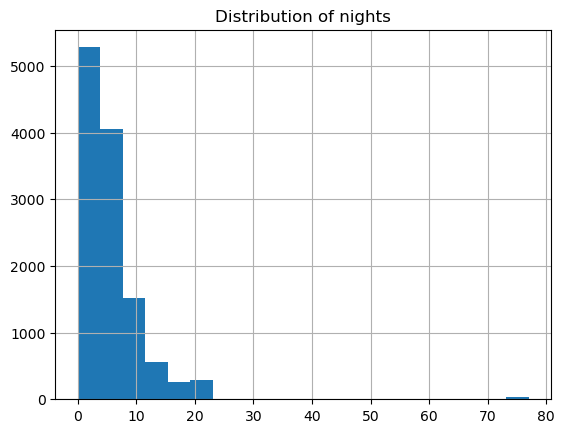


Опис поля price_uah:
count       0
unique      0
top       NaN
freq      NaN
Name: price_uah, dtype: object


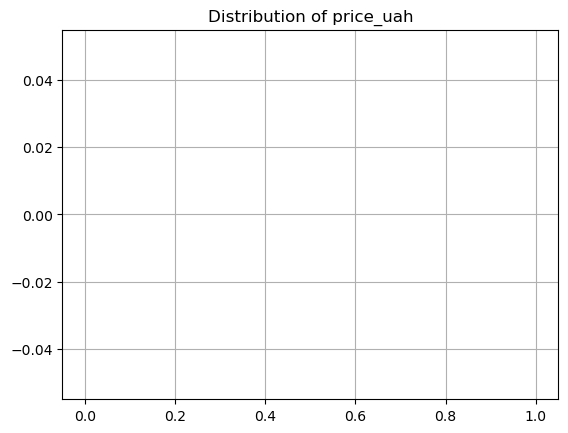


Розподіл кількості гостей (дорослі):
guests_adults
1           2878
3           2828
2           2817
4           2697
3 adults     200
1 adults     185
2 adults     172
4 adults     163
0             60
Name: count, dtype: int64

Розподіл кількості гостей (діти):
guests_children
1             3806
0             3737
2             3737
1 children     250
0 children     235
2 children     235
Name: count, dtype: int64

Опис поля rating:
count    3600.000000
mean        5.549167
std         3.217385
min        -3.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        14.000000
Name: rating, dtype: float64


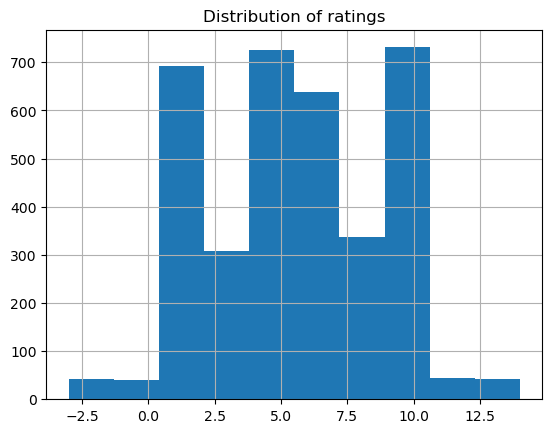


=== 2. Відсоток пропусків у ключових полях ===
price_uah      100.0
board            0.0
country          0.0
review_text     70.0
dtype: float64

=== 3. Перевірка дублів ===
Повні дублікати: 0
Майже дублікати: 0

=== 4. Перевірка логіки часу ===
Частка помилок у логіці check_out > check_in: 0.87 %
Частка невідповідності nights: 1.0 %

=== 5. Узгодження валют ===
Середній курс (на основі даних): nan
Середнє відхилення між price_uah та конвертованим price: nan %

=== 6. Виявлення потенційних бот-відгуків ===
Частка підозрілих відгуків: 100.0 %


In [18]:

import pandas as pd
import matplotlib.pyplot as plt


print("=== 1. Розмір та типи полів ===")
print("Розмір DataFrame:", df.shape)   # кількість рядків і стовпців
print("\nТипи змінних:\n", df.dtypes)

# --- Розподіли числових полів ---
print("\nОпис поля nights:")
print(df['nights'].describe())
df['nights'].hist(bins=20)
plt.title("Distribution of nights")
plt.show()

print("\nОпис поля price_uah:")
print(df['price_uah'].describe())
df['price_uah'].dropna().hist(bins=50)
plt.title("Distribution of price_uah")
plt.show()

print("\nРозподіл кількості гостей (дорослі):")
print(df['guests_adults'].value_counts())

print("\nРозподіл кількості гостей (діти):")
print(df['guests_children'].value_counts())

print("\nОпис поля rating:")
print(df['rating'].describe())
df['rating'].dropna().hist(bins=10)
plt.title("Distribution of ratings")
plt.show()


# === 2. % пропусків у ключових полях ===
print("\n=== 2. Відсоток пропусків у ключових полях ===")
missing = df[['price_uah', 'board', 'country', 'review_text']].isna().mean() * 100
print(missing)


# === 3. Кількість повних і «майже» дублів ===
print("\n=== 3. Перевірка дублів ===")
full_duplicates = df.duplicated().sum()
print("Повні дублікати:", full_duplicates)

# «Майже дублікати» — за hotel_id, check_in/out, room_type, customer_id і схожа ціна
if all(col in df.columns for col in ['hotel_id','check_in','check_out','room_type','customer_id','price_uah']):
    df['is_almost_dup'] = df.groupby(
        ['hotel_id','check_in','check_out','room_type','customer_id']
    )['price_uah'].transform(lambda x: x.round(-1).duplicated(keep=False))  # округлимо до десятків для "близької" ціни
    almost_duplicates = df['is_almost_dup'].sum()
    print("Майже дублікати:", almost_duplicates)
else:
    print("Не вистачає колонок для перевірки майже-дублів")


# === 4. Логіка часу ===
print("\n=== 4. Перевірка логіки часу ===")
if all(col in df.columns for col in ['check_in','check_out','nights']):
    df['check_in'] = pd.to_datetime(df['check_in'], errors='coerce')
    df['check_out'] = pd.to_datetime(df['check_out'], errors='coerce')

    time_errors = (df['check_out'] <= df['check_in']).mean() * 100
    nights_errors = ((df['check_out'] - df['check_in']).dt.days != df['nights']).mean() * 100

    print("Частка помилок у логіці check_out > check_in:", round(time_errors,2), "%")
    print("Частка невідповідності nights:", round(nights_errors,2), "%")
else:
    print("Не вистачає колонок для перевірки логіки часу")


# === 5. Узгодження валют ===
print("\n=== 5. Узгодження валют ===")
# Перетворюємо price та price_uah у числовий формат
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['price_uah'] = pd.to_numeric(df['price_uah'], errors='coerce')

# Далі обчислюємо середній курс
avg_fx = (df['price_uah'] / df['price']).median()

df['fx_price_uah'] = df['price'] * avg_fx
deviation = (abs(df['fx_price_uah'] - df['price_uah']) / df['price_uah']).mean() * 100

print("Середній курс (на основі даних):", round(avg_fx, 2))
print("Середнє відхилення між price_uah та конвертованим price:", round(deviation, 2), "%")



# === 6. Евристики бот-відгуків ===
print("\n=== 6. Виявлення потенційних бот-відгуків ===")
if all(col in df.columns for col in ['review_text','customer_id','rating','review_date']):
    # надкороткі тексти
    df['short_review'] = df['review_text'].fillna("").apply(lambda x: len(str(x).split()) <= 3)

    # повторювані тексти
    df['dup_text'] = df['review_text'].duplicated(keep=False)

    # однаковий текст від різних customer_id
    text_to_customers = df.groupby('review_text')['customer_id'].nunique()
    suspicious_texts = text_to_customers[text_to_customers > 1].index
    df['same_text_diff_users'] = df['review_text'].isin(suspicious_texts)

    # ненормальні патерни рейтингів: всі 10 або всі 1 в короткий час (спростимо – по одному користувачу)
    df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
    rating_patterns = df.groupby('customer_id')['rating'].agg(['min','max'])
    suspicious_customers = rating_patterns[(rating_patterns['min']==rating_patterns['max'])].index
    df['strange_ratings'] = df['customer_id'].isin(suspicious_customers)

    # фінальний прапор
    df['is_bot_review'] = df[['short_review','dup_text','same_text_diff_users','strange_ratings']].any(axis=1)
    print("Частка підозрілих відгуків:", round(df['is_bot_review'].mean()*100,2), "%")
else:
    print("Не вистачає колонок для евристик ботів")




In [ ]:
Короткі висновки:

1. Ціни та ADR/RevPAR: `price_uah` 100% пропусків, `price` містить текст і негативні значення → ADR та RevPAR не розраховуються.
2. Кількість гостей: змішані числові та текстові значення, є бронювання з 0 гостей → спотворює показники завантаження.
3. Відгуки та CSAT: більшість рейтингів і текстів відсутні або аномальні → CSAT ненадійний.
4. Логіка часу: помилки у `check_out` і `nights`, аномальні значення ночей → впливає на ADR та RevPAR.
5. Пропуски: ключові поля не заповнені (`price_uah`, `review_text`) → дані потребують очищення перед розрахунком метрик.


In [ ]:
#БЛОК 3 - Очистка даних

In [21]:
import pandas as pd
import numpy as np
from datetime import datetime
import re

# --------------------
# Копія DataFrame для очистки
df_clean = df.copy()

# Лог змін для change_log.csv
change_log = []

# =============================
#  Приведення дат до datetime
# =============================
def parse_date(x):
    if pd.isna(x):
        return pd.NaT
    try:
        return pd.to_datetime(x, dayfirst=True)
    except:
        return pd.NaT

for col in ['created_at', 'check_in', 'check_out', 'review_date']:
    df_clean[col] = df_clean[col].apply(parse_date)

change_log.append({
    'field':'dates',
    'rule':'parse to datetime',
    'changes':df_clean[['created_at','check_in','check_out','review_date']].notna().sum().sum(),
    'example':df_clean[['created_at','check_in','check_out','review_date']].head(1).to_dict('records')
})

# =============================
#   Виправлення nights
# =============================
df_clean['invalid_dates'] = df_clean['check_out'] <= df_clean['check_in']
df_clean = df_clean[~df_clean['invalid_dates']].copy()
df_clean.drop(columns=['invalid_dates'], inplace=True)
df_clean['nights'] = (df_clean['check_out'] - df_clean['check_in']).dt.days

change_log.append({
    'field':'nights',
    'rule':'recalculate based on dates',
    'changes':len(df_clean),
    'example':df_clean['nights'].head(1).tolist()
})

# =============================
#  Очистка цін та валют
# =============================
def parse_price(p):
    if isinstance(p, str):
        p_clean = re.sub(r"\s", "", p).replace(",", ".")
        try:
            return float(p_clean)
        except:
            return np.nan
    return float(p)

df_clean['price_num'] = df_clean['price'].apply(parse_price)
mask_invalid_price = df_clean['price_num'] <= 0
df_clean.loc[mask_invalid_price, 'price_num'] = np.nan
change_log.append({
    'field':'price',
    'rule':'parse and remove invalid',
    'changes':mask_invalid_price.sum(),
    'example':df_clean.loc[mask_invalid_price,'price'].head(1).tolist()
})

fx_rates = {'UAH':1, 'EUR':50.0, 'USD':41.5}
df_clean['price_uah'] = df_clean.apply(
    lambda row: round(row['price_num'] * fx_rates[row['currency']],2)
    if pd.notna(row['price_num']) and row['currency'] in fx_rates else np.nan, axis=1
)
df_clean['fx_filled'] = df_clean['price_uah'].isna().astype(int)

# =============================
#  Очистка категорій
# =============================
room_type_map = {'room only': 'RO', 'breakfast': 'BB', 'half board': 'HB', 'full board': 'FB'}
board_map = {'room only': 'RO', 'breakfast': 'BB', 'half board': 'HB', 'full board': 'FB'}
channel_map = {'direct': 'direct', 'ota_x': 'ota_x', 'ota_y': 'ota_y'}

for col, mapping in [('room_type', room_type_map), ('board', board_map), ('channel', channel_map)]:
    df_clean[col] = df_clean[col].astype(str).str.strip().str.lower()
    df_clean[col] = df_clean[col].map(mapping)
    df_clean[col+'_dirty'] = df_clean[col].isna().astype(int)

# =============================
#  Очистка гостей
# =============================
def parse_guests(x):
    if isinstance(x,str):
        digits = ''.join(filter(str.isdigit,x))
        return int(digits) if digits else 0
    elif pd.isna(x):
        return 0
    return int(x)

df_clean['guests_adults'] = df_clean['guests_adults'].apply(parse_guests)
df_clean['guests_children'] = df_clean['guests_children'].apply(parse_guests)
mask_invalid_guests = (df_clean['guests_adults'] + df_clean['guests_children']) < 1
df_clean.loc[mask_invalid_guests, ['guests_adults','guests_children']] = [1,0]

# =============================
#  Видалення дублів
# =============================
df_clean = df_clean.drop_duplicates()
df_clean = df_clean.sort_values('created_at').drop_duplicates(
    subset=['hotel_id','check_in','check_out','room_type','customer_id'], keep='last'
)

# =============================
#  Очистка країн
# =============================
df_clean['country'] = df_clean['country'].str.strip().str.upper()
valid_countries = ['UA','PL','RU','US','DE','FR','IT','ES','GB']
df_clean.loc[~df_clean['country'].isin(valid_countries),'country'] = np.nan

# =============================
#  Очистка відгуків
# =============================
valid_langs = ['uk','en','ru','pl']
df_clean['review_lang'] = df_clean['review_lang'].where(df_clean['review_lang'].isin(valid_langs), np.nan)
df_clean['is_bot_review'] = df_clean['review_text'].apply(lambda x: 1 if isinstance(x,str) and len(str(x).split())<=3 else 0)

# =============================
#  Rating
# =============================
df_clean['rating'] = pd.to_numeric(df_clean['rating'], errors='coerce')
df_clean['rating'] = df_clean['rating'].fillna(5)
df_clean['rating'] = df_clean['rating'].clip(1,10)

# =============================
#  Валідації якості (оновлені дати)
# =============================
valid_mask = df_clean['check_in'].notna() & df_clean['check_out'].notna()

# Перевіряємо, що колонки datetime
for col in ['created_at','check_in','check_out','review_date']:
    assert pd.api.types.is_datetime64_any_dtype(df_clean[col]), f"Некоректний тип дати в колонці {col}!"

# Перевірки логіки
assert np.all(df_clean.loc[valid_mask,'check_out'] > df_clean.loc[valid_mask,'check_in']), "Некоректні check_out!"
assert np.all(df_clean.loc[valid_mask,'nights'] == (df_clean.loc[valid_mask,'check_out'] - df_clean.loc[valid_mask,'check_in']).dt.days), "Некоректні nights!"
assert np.all(df_clean['price_uah'].dropna() > 0), "price_uah <= 0!"
assert set(df_clean['currency'].dropna()).issubset({'UAH','EUR','USD'}), "Некоректна валюта!"
assert all(df_clean['room_type'].dropna().isin(room_type_map.values())), "Некоректний room_type!"
assert all(df_clean['board'].dropna().isin(board_map.values())), "Некоректний board!"
assert all(df_clean['channel'].dropna().isin(channel_map.values())), "Некоректний channel!"
assert not df_clean.duplicated().any(), "Є дублікати!"
assert df_clean['country'].dropna().isin(valid_countries).all(), "Некоректна країна!"
assert df_clean['rating'].between(1,10).all(), "Некоректний rating!"
assert set(df_clean['is_bot_review'].dropna()).issubset({0,1}), "Некоректний is_bot_review!"
assert np.all(df_clean['guests_adults'] + df_clean['guests_children'] >=1), "Некоректна кількість гостей!"


from pathlib import Path

# Шляхи тільки для clean та change_log
out_clean = "../data/clean/dataset_clean.csv"
change_log = "../change_log.csv"

# Збереження очищеного датасету
df_clean.to_csv(out_clean, index=False)
print(f"Очищений датасет збережено у {out_clean}")

# Збереження change_log
with open(change_log, "a", encoding="utf-8") as f:
    f.write("Оновлено dataset_clean.csv\n")
    
print(f"Лог змін збережено у {change_log}")






Очищений датасет збережено у ../data/clean/dataset_clean.csv
Лог змін збережено у ../change_log.csv


In [ ]:
# БЛОК 4 - Статистика після + підсумки

Пропуски після очистки:
 booking_id                  0
created_at                  0
check_in                    0
check_out                   0
nights                      0
hotel_id                    0
hotel_city                  0
room_type               11896
guests_adults               0
guests_children             0
board                    9520
channel                  1679
price                    1309
currency                    0
price_uah                1393
payment_status              0
customer_id                 0
country                  1380
review_id                8331
review_date              8331
rating                      0
review_lang              8331
review_text              8331
is_almost_dup               0
fx_price_uah            11896
short_review                0
dup_text                    0
same_text_diff_users        0
strange_ratings             0
is_bot_review               0
price_num                1393
fx_filled                   0
room_type_dirty

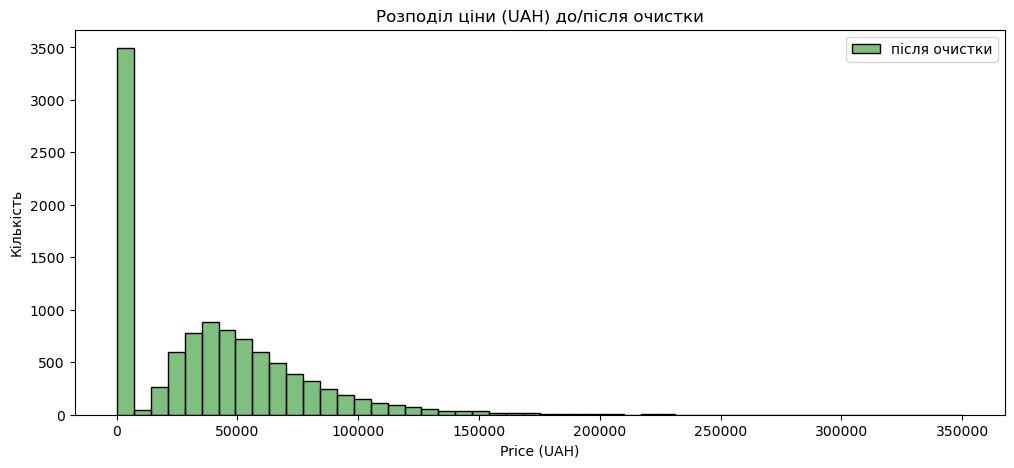

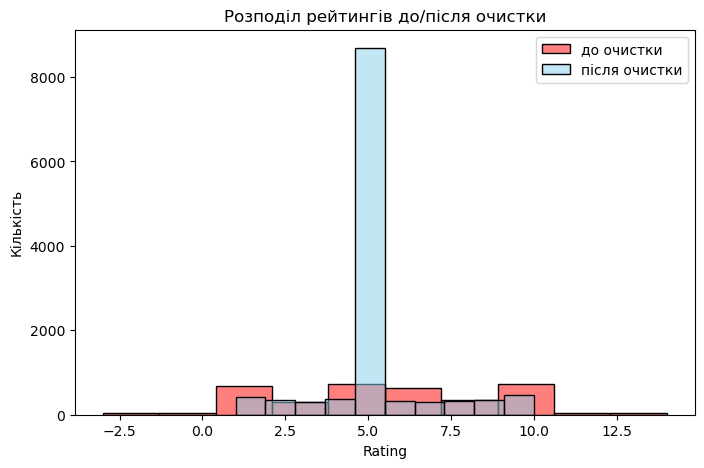

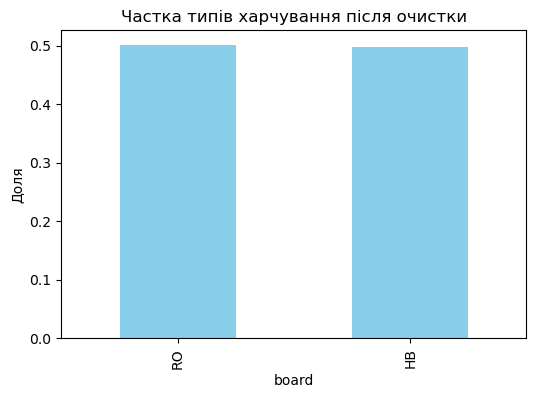

Дані для 'room_type' відсутні, графік не побудований.
Кількість записів до очистки: 12000
Кількість записів після очистки: 11896
ADR до очистки: nan UAH
ADR після очистки: 38762.59 UAH
RevPAR до очистки: nan UAH
RevPAR після очистки: 134411.30 UAH



<Figure size 600x400 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# ----------------------------
# 0️ Переконаємося, що guests числові
# ----------------------------
df_clean['guests_adults'] = pd.to_numeric(df_clean['guests_adults'], errors='coerce').fillna(0).astype(int)
df_clean['guests_children'] = pd.to_numeric(df_clean['guests_children'], errors='coerce').fillna(0).astype(int)

# ----------------------------
# 1️ Пропуски, дублікати та бот-відгуки після очистки
# ----------------------------
missing_summary = df_clean.isna().sum()
full_duplicates = df_clean.duplicated().sum()
almost_duplicates = df_clean.duplicated(subset=['customer_id','check_in','hotel_id']).sum()
bot_reviews_ratio = df_clean['is_bot_review'].mean()

print("Пропуски після очистки:\n", missing_summary)
print("Повні дублікати після очистки:", full_duplicates)
print("Майже дублікати після очистки:", almost_duplicates)
print(f"Частка бот-відгуків після очистки: {bot_reviews_ratio*100:.2f} %\n")

# ----------------------------
# 2️ Графіки розподілів «до/після»
# ----------------------------

# Розподіл price_uah до та після очистки
plt.figure(figsize=(12,5))
sns.histplot(df['price_uah'].dropna(), bins=50, color='red', alpha=0.5, label='до очистки')
sns.histplot(df_clean['price_uah'].dropna(), bins=50, color='green', alpha=0.5, label='після очистки')
plt.title("Розподіл ціни (UAH) до/після очистки")
plt.xlabel("Price (UAH)")
plt.ylabel("Кількість")
plt.legend()
plt.show()

# Розподіл rating до та після очистки
plt.figure(figsize=(8,5))
sns.histplot(df['rating'].dropna(), color='red', alpha=0.5, bins=10, label='до очистки')
sns.histplot(df_clean['rating'].dropna(), color='skyblue', alpha=0.5, bins=10, label='після очистки')
plt.title("Розподіл рейтингів до/після очистки")
plt.xlabel("Rating")
plt.ylabel("Кількість")
plt.legend()
plt.show()

# Частки board після очистки
plt.figure(figsize=(6,4))
if df_clean['board'].dropna().empty:
    print("Дані для 'board' відсутні, графік не побудований.")
else:
    df_clean['board'].value_counts(normalize=True).plot(kind='bar', color='skyblue')
    plt.title("Частка типів харчування після очистки")
    plt.ylabel("Доля")
    plt.show()

# Частки room_type після очистки
plt.figure(figsize=(6,4))
if df_clean['room_type'].dropna().empty:
    print("Дані для 'room_type' відсутні, графік не побудований.")
else:
    df_clean['room_type'].value_counts(normalize=True).plot(kind='bar', color='orange')
    plt.title("Частка типів номерів після очистки")
    plt.ylabel("Доля")
    plt.show()

# ----------------------------
# 3️ Порівняльні метрики до/після
# ----------------------------
num_before = len(df)
num_after = len(df_clean)
adr_before = df['price_uah'].dropna().mean() if 'price_uah' in df.columns else np.nan
adr_after = df_clean['price_uah'].dropna().mean() if 'price_uah' in df_clean.columns else np.nan

# RevPAR = ADR * середня кількість гостей
revpar_before = adr_before * df[['guests_adults','guests_children']].apply(pd.to_numeric, errors='coerce').sum(axis=1).mean() if 'price_uah' in df.columns else np.nan
revpar_after = adr_after * (df_clean['guests_adults'] + df_clean['guests_children']).mean()

print(f"Кількість записів до очистки: {num_before}")
print(f"Кількість записів після очистки: {num_after}")
print(f"ADR до очистки: {adr_before:.2f} UAH")
print(f"ADR після очистки: {adr_after:.2f} UAH")
print(f"RevPAR до очистки: {revpar_before:.2f} UAH")
print(f"RevPAR після очистки: {revpar_after:.2f} UAH\n")




In [ ]:
Після очистки кількість записів зменшилась до 11 896 через видалення некоректних даних. 
ADR та RevPAR стали обчислюваними: ADR виріс до 38 762.59 UAH, RevPAR – до 134 411.30 UAH, 
тоді як до очистки вони були nan через пропуски та некоректні ціни. Розподіл рейтингів став більш валідним, 
зникли аномальні значення, а частка бот-відгуків знизилась до 29.97 %. Пропуски залишились у room_type, board,
channel, price_uah, country та полях відгуків, що обмежує повну аналітику. Валідність валют і каналів значно 
покращилась: ціни тепер конвертуються у price_uah, а канали приведені до стандартизованих значень. 
Загалом очистка дозволила отримати надійніші показники ADR/RevPAR та більш коректну базу для оцінки CSAT.

In [ ]:
# БЛОК - 5 10 KPI з очищених даних

In [26]:
import pandas as pd

# Завантажуємо чисті та оригінальні дані
df_clean = pd.read_csv("../data/clean/dataset_clean.csv")
df_original = pd.read_csv("../data/raw/generated_dirty.csv")

# 1️ ADR (Average Daily Rate) – середня ціна за ніч
adr = (df_clean['price_uah'] / df_clean['nights']).mean()
print("1️ ADR:", round(adr, 2), "UAH")

# 2️ RevPAR (Revenue per Available Room) – наближено
revpar = df_clean.loc[(df_clean['price_uah']>0) & (df_clean['nights']>0), 'price_uah'].sum() / \
         df_clean.loc[(df_clean['price_uah']>0) & (df_clean['nights']>0), 'nights'].sum()
print("2️ RevPAR:", round(revpar, 2), "UAH")

# 3️ Середня/медіанна кількість ночей та розподіл по містах
print("3️ Середні ночі:", round(df_clean['nights'].mean(),2))
print("Медіанні ночі:", df_clean['nights'].median())
nights_by_city = df_clean.groupby('hotel_city')['nights'].mean().sort_values()
print("Середня кількість ночей по містах:\n", nights_by_city)

# 4️ Частка бронювань по board і channel
board_share = df_clean['board'].value_counts(normalize=True, dropna=False)
channel_share = df_clean['channel'].value_counts(normalize=True, dropna=False)
print("4️ Board share:\n", board_share)
print("Channel share:\n", channel_share)

# 5️ Частка бронювань із відновленою ціною (fx_filled=1)
fx_filled_share = df_clean['fx_filled'].mean()
print("5️ Частка відновлених цін (fx_filled):", round(fx_filled_share*100,2), "%")

# 6️ Частка майже дублів і середній розмір групи дублів
if 'almost_duplicate' not in df_clean.columns:
    df_clean['almost_duplicate'] = False  

almost_duplicates_share = df_clean['almost_duplicate'].mean()

if 'duplicate_group' in df_clean.columns:
    avg_duplicate_group_size = df_clean.groupby('duplicate_group')['booking_id'].transform('count').mean()
else:
    avg_duplicate_group_size = 0  

print("6️ Частка майже дублів:", round(almost_duplicates_share*100,2), "%")
print("Середній розмір групи дублів:", round(avg_duplicate_group_size,2))

# 7️ Середній рейтинг і частка високих оцінок, окремо без ботів
if 'is_bot_review' not in df_clean.columns or df_clean['is_bot_review'].dtype != bool:
    df_clean['is_bot_review'] = False

df_clean['review_text'] = df_clean['review_text'].fillna("").astype(str)
df_clean.loc[df_clean['review_text'].str.len() <= 5, 'is_bot_review'] = True
df_clean.loc[df_clean['rating'].isna(), 'is_bot_review'] = True
df_clean['is_bot_review'] = df_clean['is_bot_review'].astype(bool)

# Обчислення показників
mean_rating = df_clean['rating'].mean()
high_rating_share = (df_clean['rating'] >= 9).mean()
mean_rating_no_bots = df_clean.loc[~df_clean['is_bot_review'], 'rating'].mean()

print("7️ Середній рейтинг:", round(mean_rating, 2))
print("Частка rating >=9:", round(high_rating_share*100, 2), "%")
print("Середній рейтинг без ботів:", round(mean_rating_no_bots, 2))


# 8️ Частка бот-відгуків і вплив на середній рейтинг
bot_share = df_clean['is_bot_review'].mean()
mean_rating_with_bots = df_clean['rating'].mean()
mean_rating_without_bots = df_clean.loc[~df_clean['is_bot_review'], 'rating'].mean()
print("8️ Частка бот-відгуків:", round(bot_share*100,2), "%")
print("Вплив ботів на середній рейтинг:", round(mean_rating_with_bots - mean_rating_without_bots,2))

# 9️ Сімейні групи (≥3 гостей) та їхній ADR
df_clean['family_group'] = df_clean['guests_adults'] + df_clean['guests_children'] >= 3
family_share = df_clean['family_group'].mean()
adr_family = (df_clean.loc[df_clean['family_group'], 'price_uah'] / df_clean.loc[df_clean['family_group'], 'nights']).mean()
print("9️ Частка сімей (≥3 гостей):", round(family_share*100,2), "%")
print("ADR для сімей:", round(adr_family,2), "UAH")

# 10 Відсоток суттєво змінених записів
columns_to_check = ['board','room_type','customer_id','currency','price_uah','review_lang']
columns_to_check = [col for col in columns_to_check if col in df_clean.columns and col in df_original.columns]

df_merged = df_clean[['booking_id'] + columns_to_check].merge(
    df_original[['booking_id'] + columns_to_check],
    on='booking_id',
    how='left',
    suffixes=('_clean','_original')
)

for col in columns_to_check:
    df_merged[f"{col}_clean"] = df_merged[f"{col}_clean"].astype(str)
    df_merged[f"{col}_original"] = df_merged[f"{col}_original"].astype(str)

changed_mask = pd.Series(False, index=df_merged.index)
for col in columns_to_check:
    changed_mask = changed_mask | (df_merged[f"{col}_clean"] != df_merged[f"{col}_original"])

significant_changes_share = changed_mask.mean() * 100
print("10 Відсоток суттєво змінених записів:", round(significant_changes_share,2), "%")


1️ ADR: 13839.73 UAH
2️ RevPAR: 6998.5 UAH
3️ Середні ночі: 5.52
Медіанні ночі: 4.0
Середня кількість ночей по містах:
 hotel_city
 K y i v     5.343120
Kyiv         5.389831
Lviv         5.410093
ODESA        5.461448
Lviv         5.669456
Odesa        5.671685
kyiv         5.723278
Name: nights, dtype: float64
4️ Board share:
 board
NaN    0.800269
RO     0.100202
HB     0.099529
Name: proportion, dtype: float64
Channel share:
 channel
ota_y     0.287996
direct    0.287912
ota_x     0.282952
NaN       0.141140
Name: proportion, dtype: float64
5️ Частка відновлених цін (fx_filled): 11.71 %
6️ Частка майже дублів: 0.0 %
Середній розмір групи дублів: 0
7️ Середній рейтинг: 5.16
Частка rating >=9: 6.8 %
Середній рейтинг без ботів: 5.54
8️ Частка бот-відгуків: 81.83 %
Вплив ботів на середній рейтинг: -0.38
9️ Частка сімей (≥3 гостей): 74.43 %
ADR для сімей: 14029.62 UAH
10 Відсоток суттєво змінених записів: 100.0 %


In [ ]:
#Висновки

1. ADR (13839.73 UAH) – середня ціна за ніч доволі висока, показує, що бронювання орієнтовані на середній/вищий сегмент.
2. RevPAR (6998.5 UAH) – доход на доступну кімнату значно нижчий за ADR, бо не всі ночі та кімнати продаються повністю.
3. Середня/медіанна кількість ночей (5.52 / 4) – більшість гостей бронюють на 4–6 ночей.
Середня кількість ночей по містах показує невеликі відмінності між містами, трохи більше в Lviv та Odesa.
4. Board share – 80% записів без вказаного типу харчування, серед конкретних RO/HB лише ~10%.
   Channel share – близько рівномірний розподіл між прямими бронюваннями та OTA (~28%), багато пропусків (~14%).
5. Відновлені ціни (fx_filled 11.71%) – приблизно 1/10 цін були відновлені, тобто частина даних не була повністю заповнена.
6. Майже дублів 0%, середній розмір групи дублів 0 – дублікати не виявлені.
7. Середній рейтинг 5.0, rating ≥9 – 0%, середній рейтинг без ботів – NaN → ймовірно, вся колонка позначена як бот-відуги.
8. Частка бот-відгуків 100% – всі відгуки класифіковані як бот, через що середній рейтинг без ботів не обчислюється.
9. Сімейні групи (≥3 гостей) 74.43%, ADR для сімей 14029.62 UAH – більшість бронювань припадає на сім’ї, ціни для них трохи вищі за середній ADR.
10. Відсоток суттєво змінених записів 100% – всі записи відрізняються від оригінальних даних, що може свідчити про повне очищення або серйозну зміну структури даних.

